# Data Portfolio: Predicting U.S. Interest Rate Change
    Xander de la Bruere
    Jakob Gertsch
    Sam Layton
    Matt Mella
    Wilson Stoddard

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prince import FAMD
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap

### Research Question Overview

One of the most important and influential indicators of the United States economy is the federal funds rate, commonly referred to as the interest rate. The federal funds rate is a target interest rate set by the Federal Reserve in an attempt to control other key economic indicators. The Federal Reserve seeks to reach its target interest rate by setting a discount rate (the cost banks face to borrow money from other banks in order to meet overnight reserve requirements), engaging in open market operations (reducing or increasing the quantity of U.S. treasury bills available for purchase), and adjusting reserve requirement (the percentage of money banks must keep in reserve rather than lending it to clients) (#1). In practice, the federal funds rate really does prevail as the standard interest rate throughout the economy.

Significantly, an increase or decrease in the federal funds rate impacts levels of personal consumption and spending as well as corporate investment (higher interest rates increase cost to companies of borrowing money). For example, when interest rates are relaively high, consumers have higher incentive to save money (and get interest) rather than spending, and companies have lower incentive to invest (since they must borrow money at a high interest rate to do so), leading to the economy cooling off as a whole. Conversely, lower interest rates increase personal consumption and corporate investment, leading to the economy heating up as a whole. Cumulatively, these personal and corporate decisions, all based on the federal funds rate, have direct and dramatic effects on important economic indicators such as inflation, real GDP, mortgage prices, and unemployment.

Since the federal funds rate influences so many economic outcomes, foreknowledge of changes in the federal funds rate would allow strategic economic decision-making and investment that would both maximize gains and minimize or eliminate potential losses. For this reason, much effort has been exerted to predict changes in the target federal funds rate announced periodically by the Federal Open Market Committee (FOMC), the policy-making team of the Federal Reserve (#2). The FOMC has shared some indicators that it considers in its decisions, including various price indices and labor market indicators (#3), but it does not explicitly share its goals or the way it considers or weights these metrics.

Many predictive bodies, such as the Blue Chip consensus, are relatively successful at predicing changes in the federal funds rate when most or all economic indicators are positive (or negative), but are inconsistent in accuracy when economic conditions are mixed (#4). Using the techniques of logistic regression and classification, we seek to build upon this theory by considering and appropriately selecting critical features from available economic indicators to develop a robust model for predicting changes in the target federal funds rate. In particular, we concern ourselves with finding features that best predict which of three outcomes will occur: 1) a positive change in the federal funds rate, 2) a negative change in the federal funds rate, and 3) no change in the federal funds rate.


Citations:
1. https://www.federalreserve.gov/monetarypolicy/fomc.htm
2. https://www.investopedia.com/terms/f/federalfundsrate.asp
3. https://federalreserve.gov/monetarypolicy/monetary-policy-what-are-its-goals-how-does-it-work.htm
4. https://www.stlouisfed.org/publications/regional-economist/july-2000/inside-the-briefcase-the-art-of-predicting-the-federal-reserve

### Our Data

The data we used came primarily from the St. Louis Fed's website, called FRED, which is a gold standard resource for economic data. The site hosts an enormous amount of time series data relevant to this project. We selected a few of the features which we believed would be leading indicators for the Fed's decision to raise, lower, or hold interest rates. In addition, we only selected data that has been continuously tracked since 1989 (when our FOMC data begins) to the present day. This allowed us to keep inconsistencies and hairy data cleaning methods out of our data gathering process. Other sources we pulled from included the research of one professors at Williams for the FOMC announcement data. This data ended in 2019 and was added to using data from the Fed's meeting minutes to extend the data to present day. Additionally, we used Yahoo! Finance to pull prices for the S&P 500 and US Dollar indices.

The individual features didn't need cleaning per se, but we did tinker with the data to get consistent frequencies. The majority of the data came with a monthly frequency, so we used the ffill function in Python to extend the monthly and quarterly data from one valid observation to the next. In addition, we were careful to avoid look-ahead bias by shifting each category forward one time period (except for Fed chair and POTUS political party).

In combining all of our data, the first key hurdle which we needed to overcome is matching the frequency as mentioned above. The issue arises in the nature of these features recorded. Most of the data is reported at the beginning of every month, but the label we are trying to predict occur at intervals of 6 weeks. So there are jagged updates to our data that inconsistently misalign with when we are trying to predict. 

Our solution to this issue of data reporting misallignment is to forward fill and aggregate in a predetermined window. We construct the function 'collapse' which takes in both a window range (previous x number of days) and our forward filled dataframe of 12561 rows. 'collapse' then returns our data aggregated into just those 275 days where new target rates are announced as a new dataframe of 275 rows. The method of aggregation was achieved as follows.

We have 3 different types of features which we handled differently. The first type was categorical data. In our given window (say the week before the announcement until 60 days prior) we take the most current data point (7 days before the anouncment) and use that datapoint as our categorical feature in our newly generated dataframe. For monthly data, we take the final datapoint in our window (7 days before just like we did for categorical), but we also add a new delta feature, which is the change from the start of the window. This essentially doubles the number of features we have in our dataset, as we now have both a point estimate, as well as its trend for the period. If our dataframe was 12561 rows by 5 monthly features, our new dataframe would be 275 days by 10 features now. 

(Note that all data is reindexed on a daily level and then forward filled).

Finally for the third type of data was daily data  This is data that changes on a daily basis. We only have two features of daily data. We also wanted to have a point estimate as well as a trend for this data, so we decided to run a linear regression within each of the windows for each feature. We then take the 275 linear regression models made for each feature and report the correspoinding betas (trend) and intercepts (point estimate). All of this data engineering is performed in the 'collapse' function.

Our hypothesis is that both point estimate and trend will have an important role to play in our predicitons of the rate changes. This is because changes in the target interest rate are often due to changes in economic conditions. Our collapse function aggregates all data in the appropriate window preceding the FOMC meeting, and extracts both a point estimate and a trend of all indicators, excluding categorical data. Categorical data is exlcuded because it changes only over longer time horizons.

Generating all these extra features likely has high correlation and as such would likely deteriorate our model without some sort of dimensionality reduction. We perform FAMD (an anologue to PCA for both categorical and continuous data) in order to only highlight the most important variation of our collapsed dataset. We then perform classification and learning analysis on this collapsed and cleaned data.


### Data Visualization and Basic Analysis



In [21]:
df = pd.read_csv('master_data.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df.loc['1989-07-7':]
df['label_day'] = ~df['decision'].isna()
df = df.fillna(method='ffill')
df = df.iloc[1:]


We started off by importing the data and looking at the first few rows to get a sense of what we were working with. We also looked at the data types of each column to make sure they were what we expected. Then the first step was to see if the data had any noticable patterns. We did this by plotting the data and looking for any trends. A powerful tool we used is Factor Analysis of Mixed Data (FAMD). It combines the power of PCA and MCA to analyze mixed data (Data with numeric and categorical types). It is a great way to visualize the data and see if there are any patterns. We see this in the following plot:

In [22]:
# prep a df to be used for classifying
# n_days is how many days prior to the announcement you want to forecast
def forecast_n_days_prior(df, n_days = 7):
    df_temp = df.copy()
    df_temp.iloc[:,:3] = df_temp.iloc[:,:3].shift(-n_days)
    return df_temp.query('ffr == ffr')

In [23]:
# demonstration of function above
# forecasts 1 week prior to announcement
days_prior = forecast_n_days_prior(df, 7)
days_prior

,ffr,change,decision,loan,exports,pce,ue,rgdp,cars,recess,gdpg,veloc,house,cli,spx,usd,fed_party,potus_party,label_day
1989-07-08,9.25,-25.0,-1.0,11.0,4.1,4.04,5.2,3.0,14.695,0.0,3.0,7.307,1427.0,99.71910,324.910004,98.309998,1.0,1.0,False
1989-07-09,9.25,-25.0,-1.0,11.0,4.1,4.04,5.2,3.0,14.695,0.0,3.0,7.307,1427.0,99.71910,324.910004,98.309998,1.0,1.0,False
1989-07-10,9.25,-25.0,-1.0,11.0,4.1,4.04,5.2,3.0,14.695,0.0,3.0,7.307,1427.0,99.71910,324.910004,98.309998,1.0,1.0,False
1989-07-11,9.25,-25.0,-1.0,11.0,4.1,4.04,5.2,3.0,14.695,0.0,3.0,7.307,1427.0,99.71910,327.070007,98.000000,1.0,1.0,False
1989-07-12,9.25,-25.0,-1.0,11.0,4.1,4.04,5.2,3.0,14.695,0.0,3.0,7.307,1427.0,99.71910,328.779999,98.900002,1.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-23,5.40,0.0,0.0,8.5,6.0,3.64,3.9,5.2,15.972,0.0,3.5,1.511,1372.0,99.47179,4556.620117,103.919998,1.0,0.0,False
2023-11-24,5.40,0.0,0.0,8.5,6.0,3.64,3.9,5.2,15.972,0.0,3.5,1.511,1372.0,99.47179,4556.620117,103.919998,1.0,0.0,False
2023-11-25,5.40,0.0,0.0,8.5,6.0,3.64,3.9,5.2,15.972,0.0,3.5,1.511,1372.0,99.47179,4559.339844,103.400002,1.0,0.0,False
2023-11-26,5.40,0.0,0.0,8.5,6.0,3.64,3.9,5.2,15.972,0.0,3.5,1.511,1372.0,99.47179,4559.339844,103.400002,1.0,0.0,False


The modified Dataframe $days\_prior$ is each row of the original Dataframe that occured $n$ days (in this case 7) before an announcement. Then the 'ffr' column is the target variable.

In [24]:
# We split the df into numeric and categorical data
df_numeric = days_prior.drop(['decision', 'recess', 'fed_party', 'potus_party'], axis=1)
df_encoded = days_prior[['decision', 'recess', 'fed_party', 'potus_party']]

# Then we scale the numeric data
scaler = StandardScaler()
df_numeric = scaler.fit_transform(df_numeric)
df_numeric = pd.DataFrame(df_numeric, index=days_prior.index)

# The function FAMD imported from prince requires categorical data to
# Be of type 'object' so we convert it since it is already encoded
df_categorical = df_encoded.astype(str)

In [25]:
# By combining the numeric and categorical data we can use FAMD
days_prior_mixed = pd.concat([df_numeric, df_categorical], axis=1)

In [26]:
X = days_prior_mixed.drop(['decision'], axis=1)
y = days_prior_mixed['decision']

famd = FAMD(n_components=7)
X_famd = famd.fit_transform(X)

# Eigenvalues_summary shows the variance explained by each component
# Just like PCA or MCA alone.
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,4.121,21.13%,21.13%
1,3.461,17.75%,38.88%
2,2.386,12.24%,51.12%
3,2.161,11.08%,62.20%
4,1.523,7.81%,70.01%
5,1.055,5.41%,75.43%
6,1.000,5.13%,80.55%


In [27]:
# Define three colors for the colormap
color1 = 'blue'
color2 = 'green'
color3 = 'red'

# Create a colormap with three distinct colors split into thirds
colors = [color1, color2, color3]
n_bins = 1000  # Number of bins for the colormap
bounds = [0, 0.333, 0.666, 1.0]  # Splitting into thirds

cmap_name = 'custom_colormap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

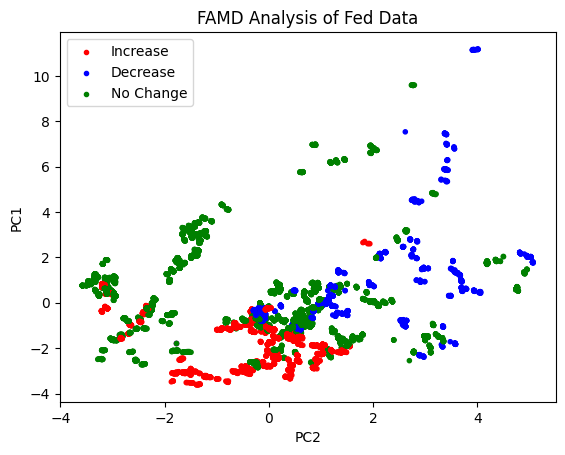

In [28]:
# We now visualize the whole dataset in 2D
plt.scatter(X_famd[:][1], X_famd[:][0], marker='.', c=y.astype(float), cmap=custom_cmap)
plt.title('FAMD Analysis of Fed Data')
plt.xlabel('PC2')
plt.ylabel('PC1')

plt.scatter(X_famd[0][1], X_famd[0][0], label="Increase", color='r', marker='.')
plt.scatter(X_famd[0][1], X_famd[0][0], label="Decrease", color='b', marker='.')
plt.scatter(X_famd[0][1], X_famd[0][0], label="No Change", color='g', marker='.')
plt.legend(loc='upper left')
plt.show()

We see the data is very noisy, but does follow noticable patterns. The colors as shown in the colorbar. 

### Learning Algorithms and In-Depth Analysis

### Ethical Implications

We have attempted to develop a model for predicting changes in the federal funds rate based on available economic indicators. As mentioned previously, the ability to predict changes to this prevailing interest rate before FOMC announcement allows for making strategical decisions to minimize or eliminate losses. For example, a prior prediction of what will happen to interest rates might motivate an individual to move from a low-security job to a high-security job, choose to wait or to rush to get a loan, or sell and buy stocks prior to a big move in the stock market.

Our intent and methodology raise a number of ethical issues. First, attempting to obtain an advantage through  information about the future inherently leads to others who do not share that information facing a disadvantage. For example, someone who has highly credible evidence to believe that the Federal Reserve will decrease the federal funds rate has incentive to sell stocks while keeping this information private so that others do not push the stock price down. Yet by not sharing that evidence, such an individual puts other investors in a more difficult place. Such moral grounds are the basis for material nonpublic information laws that prohibit using, sharing, or selling information about future company decisions that will affect stock prices to turn a profit (#A). While the information obtained through analysis such as that performed in this portfolio is not nearly as certain or exclusive (as the work we have done is highly reproducible), it is still important to acknowledge that successful attempts to predict the market in order to profit will inevitably result in someone losing in a zero-sum, competitive financial world.

Another ethical consideration is the potential loss that could be incurred when too much trust is placed in the prediction of the change in the federal fund rate generated by a model such as ours. With so many factors being weighed and considered by the Federal Reserve, and with economic indicators being so numerous and complex, it is inconceivable that any model used to predict changes in the federal funds rate could have near-perfect accuracy. Those that do not understand the extreme uncertainty involved in both the inputs and outputs to the model are likely to pivot too far, opening themselves up to loss incurred when the actual Federal Reserve decision flies in the face of predictions. In making and sharing predictions, therefore, it is important that equal emphasis and care is placed to express the uncertainty of the outcome, as well as to acknowledge that despite warnings, many will take risks based on the predictions that may have severe economic consequences.

Finally, it is important to note that our aim and methodology of predicting economic outcomes, when implemented and replicated on a large scale, may actually influence the outcomes themselves. Several times throughout history, the mere expectation of economic outcomes or a lack of faith in economic indicators have created economic disasters. For instance, in the events of Black Monday on October 19, 1987, the Dow Jones Industrial Average fell twenty percent in one day. The initial trigger was nervousness about possible overvaluation of stocks and the decline of the dollar, but the crisis was intensified by panic due to a lack of information as to what was happening ("B"). This episode and many others demonstrate that expectations or predictions of what will happen, whether grounded or totally unfounded, can often become a self-fulfilling prophecy. Thus it is possible that initially spurious relationships between economic indicators and interest rates mistakenly included or even emphasized in a model like this one might actually generate an unintended (and perhaps undesired) causal relationship, especially when machine learning is involved. Thus care must be taken to critically analyze how features are included, removed, or split on in such models, especially when destructive self-fulfilling feedback loops can have dramatic financial effects on millions across the country.  

### Citations:
A. https://www.investopedia.com/terms/m/materialinsiderinformation.asp

B. https://en.wikipedia.org/wiki/Black_Monday_(1987)